# GPC-CS Template

This notebook is designed to analyze and visualize  the effects of a specific genetic variant on various phenotypic features. You need to fill in the following sections with actual code and data to perform the analysis.

The cells labeled with <span style='color: red'>RED text</span> should be tailored for each analysis. The values of the other cells are the recommended values, and do not need to be touched, unless there is a very good reason to do so.

# [GeneName] and Associated Syndrome

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[[Syndrome Name]](link_to_syndrome) is an [type of disease, e.g. autosomal dominant] disease characterized by [describe main features of the syndrome]. The syndrome is caused by pathogenic variants in the [[GeneName]](link_to_gene) gene.

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One/Two/Several previous publications have reported candidate genotype-phenotype correlations in [Syndrome Name].

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) report:

> [Quote relevant finding from the study]

<!-- TODO: Add instructions for finding more comprehensive citations and explain the next steps in your analysis. -->

TODO -- find a more comprehensive collection of citations for [GeneName]. At the end of the introduction for a gene, we would write something like this:

> Example: Therefore, we tested missense vs other variants (inspection of the distribution of variants showed that the other variant categories in our dataset are [list other variant categories], all of which we deemed to be null variants for the purposes of this analysis). We also tested the two most common missense variants ([DETAILS]) for correlations.


# Imports 

In [1]:
import gpsea

f"Using gpsea version {gpsea.__version__}"

'Using gpsea version 0.9.1'

## Load HPO

Most of the analyses use HPO. Therefore, let's load it here!

In [12]:
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
f"Loaded HPO v{hpo.version}"

'Loaded HPO v2024-12-12'

# Loading Phenopackets & Gene Variant Data

## Choose the preferred transcript and protein sequence

The prefered transcript can be found by searching on the gene symbol in [ClinVar](https://www.ncbi.nlm.nih.gov/clinvar/). By entering the accession number in [NCBI Nucleotide](https://www.ncbi.nlm.nih.gov/nuccore/?), you can find the corresponding protein accession number.


<span style='color: red'>IMPORTANT - gene symbol, mane TX accession, as well as the corresponding protein identifier should be tailored to your analysis!</span>

Here we use *WWOX* as an example:

In [13]:
gene_symbol = 'WWOX'
mane_tx_id = 'NM_016373.4'
mane_protein_id = 'NP_057457.1'

## Load phenopackets

Load phenopackets from Phenopacket Store:

In [14]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.22'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

f"Loaded {len(phenopackets)} phenopackets"

'Loaded 38 phenopackets'

If Phenopacket Store is not an option, there are also other ways to load phenopackets.
Consult the [Input data](https://monarch-initiative.github.io/gpsea/stable/user-guide/input-data.html) section of the user guide.

## Create cohort

Transform the phenopackets into a cohort and perform Q/C:

In [19]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopacket_folder

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopacket_folder(
    #phenopackets=phenopackets, 
    pp_directory="../../../phenopacket-store/notebooks/WWOX/phenopackets/",
    cohort_creator=cohort_creator,
)
f"Loaded {len(cohort)} individuals"

Individuals Processed: 38individuals [00:05,  6.95individuals/s]


'Loaded 38 individuals'

## Show Q/C issues (if any)

Test if there are any issues:

In [6]:
qc.summarize()

Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    variants
      #0
       warnings:
       ·Individual PMID_30356099_Patient_1 has an error with variant 16_78386858_78386858_A_--45894bp--. Try again or remove variant from testing... Expected a result but got an Error. See log for details.


# Explore cohort

Generate reports to simplify exploring the cohort.

## Cohort summary

In [7]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
report

n,HPO Term
36,Global developmental delay
32,EEG abnormality
29,Epileptic encephalopathy
20,Hypokinesia
19,Thin corpus callosum
19,Reduced eye contact
15,Spasticity
14,Cerebral atrophy
12,Bilateral tonic-clonic seizure
12,Epileptic spasm


## Protein sequence effects

Summarize effects on the protein sequence

In [8]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVariantViewer


pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

viewer = ProteinVariantViewer(
    protein_metadata=protein_meta,
    tx_id=mane_tx_id,
)
protein_report = viewer.process(cohort)
protein_report

Count,Name,Type,Coordinates,Variants
5,Disordered,Region,2 - 23,p.Thr12Met; p.Met1_?137; p.Glu17Lys; p.Asp16SerfsTer63
10,WW 1,Domain,17 - 49,p.Glu17Lys; p.Met1_?137; p.Pro47Thr; p.Pro47Arg; p.Trp44Ter
3,Nuclear localization signal,Motif,51 - 55,p.Met1_?137; p.Arg54Ter
1,WW 2,Domain,58 - 90,p.Met1_?137
25,Interaction with MAPT,Region,126 - 414,p.Arg264Ter; p.Val365AlafsTer163; p.Lys200Glu; p.Gln230Pro; p.Ser304Phe; p.Ser318Leu; p.Cys380LeufsTer149; p.Ser304Tyr; p.Leu239Arg; p.Gly137Glu; p.Trp335Ter; p.Met1_?137; p.Gly372Arg; p.His150Pro; p.Glu306AspfsTer21; p.His236AlafsTer34; p.Lys297Ter
3,,Binding site,132 - 137,p.Met1_?137; p.Gly137Glu
8,Mediates targeting to the mitochondria,Region,210 - 273,p.Gln230Pro; p.Arg264Ter; p.Leu239Arg; p.His236AlafsTer34
0,,Binding site,261 - 260,
0,Proton acceptor,Active site,294 - 293,


Plot variant distribution with respect to the protein sequence, domains, and other features

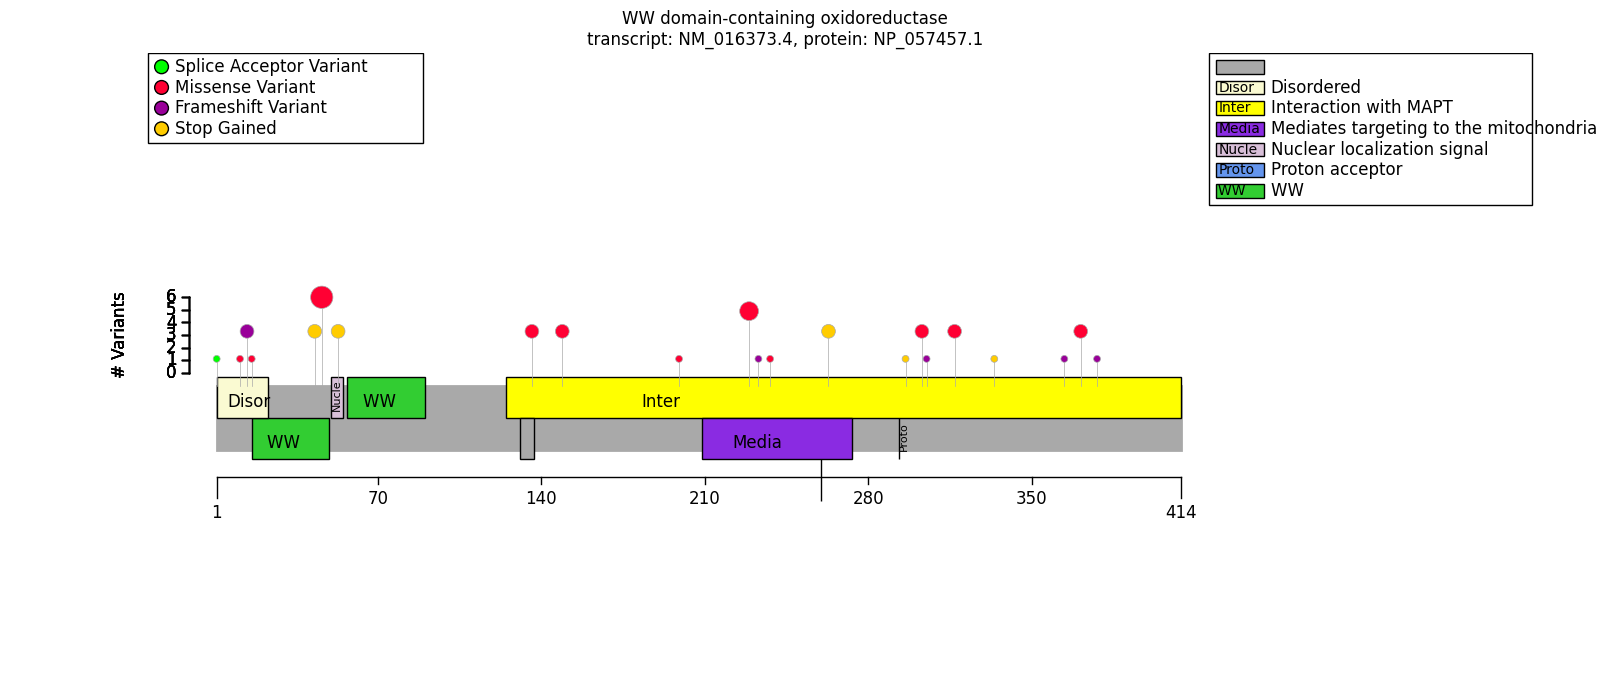

In [9]:
from gpsea.view import ProteinVisualizer

drawer = ProteinVisualizer()
_ = drawer.draw_fig(pvis=pvis)

## Allele report

In [10]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
report

Count,Variant key,HGVS,Overlapping Exons,Effects
4,16_78108454_78108454_C_A,c.139C>A (p.Pro47Thr),2,missense
4,16_78424953_78424953_A_C,c.689A>C (p.Gln230Pro),7,missense
3,16_78386858_78425054_--38197bp--_A,c.517_791del (p.His173IlefsTer5),"6, 7","splice acceptor, splice donor, splice donor 5th base, coding sequence, intronic"
3,SO:1000029_HGNC:12799_WWOX,SV involving WWOX (p.?),,chromosomal deletion
3,16_78386858_78432751_--45894bp--_A,c.517_1056del (p.His173_Met352del),"6, 7, 8","splice acceptor, splice donor, splice donor 5th base, coding sequence, intronic"
2,16_78108446_78108446_G_A,c.131G>A (p.Trp44Ter),2,stop gained
2,16_78109777_78109777_G_T,c.173-1G>T (-),-,splice acceptor
2,16_78425054_78425054_C_T,c.790C>T (p.Arg264Ter),7,"stop gained, splice region"
2,16_79211665_79211665_G_C,c.1114G>C (p.Gly372Arg),9,missense
2,16_78164222_78164222_A_C,c.449A>C (p.His150Pro),5,missense


# Genotype phenotype analyses

## Missense/Missense vs. Missense/Other or Other/Other

### Genotype predicate

Test Missense variants vs. the others.

<span style='color: red'>IMPORTANT - genotype predicate should be tailored to your analysis!</span>

In [11]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate

is_missense = VariantPredicates.variant_effect(
    effect=VariantEffect.MISSENSE_VARIANT,
    tx_id=mane_tx_id,
)

gt_predicate = biallelic_predicate(
    is_missense,
    a_label="Missense", b_label="Other",
    partitions=[(0,), (1, 2,)]
)
gt_predicate.group_labels

ModuleNotFoundError: No module named 'gpsea.analysis.predicate.genotype'

### Phenotype predicate

Test all HPO terms

In [12]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)

191

### MTC filter, MTC correction, and statistic

- HPO MTC filter
- Benjamini-Hochberg
- Fischer Exact test

In [13]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis
from gpsea.analysis.pcats.stats import FisherExactTest


mtc_filter = HpoMtcFilter.default_filter(hpo=hpo)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()


analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,    
)

### Execute the analysis

In [14]:
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

### Show MTC report

In [15]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(missense_result)
report

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,19
HMF03,Skipping term because of a child term with the same individual counts,8
HMF08,Skipping general term,39
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,101


### Summarize the HPO terms

In [16]:
from gpsea.view import summarize_hpo_analysis

missense_report = summarize_hpo_analysis(hpo=hpo, result=missense_result)
missense_report

Allele group                                       Missense/Missense          \
                                                               Count Percent   
Generalized non-motor (absence) seizure [HP:000...               2/5     40%   
Epileptic spasm [HP:0011097]                                     0/5      0%   
Round face [HP:0000311]                                          2/5     40%   
Thin corpus callosum [HP:0033725]                                3/4     75%   
Abnormal corpus callosum morphology [HP:0001273]                 3/3    100%   
Abnormal cerebral morphology [HP:0002060]                        4/4    100%   
Abnormal brain morphology [HP:0012443]                           6/6    100%   
Morphological central nervous system abnormalit...               6/6    100%   
Seizure [HP:0001250]                                           11/11    100%   
Bilateral tonic-clonic seizure [HP:0002069]                      9/9    100%   
Epileptic encephalopathy [HP:0200134]                            5/5    100%   
Global developmental delay [HP:0001263]                        11/11    100%   
Neurodevelopmental abnormality [HP:0012759]                    11/11    100%   
Abnormal muscle tone [HP:0003808]                                4/4    100%   
EEG abnormality [HP:0002353]                                     8/8    100%   
Upper motor neuron dysfunction [HP:0002493]                      4/4    100%   
Spasticity [HP:0001257]                                          4/6     67%   
Hypertonia [HP:0001276]                                          4/4    100%   
Cerebral atrophy [HP:0002059]                                    3/5     60%   
Hypokinesia [HP:0002375]                                         3/4     75%   
Diminished movement [HP:0002374]                                 3/3    100%   
Reduced eye contact [HP:0000817]                                 4/5     80%   
Abnormal eye contact [HP:0034435]                                4/4    100%   
Abnormal communication [HP:0034434]                              8/8    100%   

Allele group                                       Missense/Other OR Other/Other  \
                                                                           Count   
Generalized non-motor (absence) seizure [HP:000...                          0/17   
Epileptic spasm [HP:0011097]                                                8/17   
Round face [HP:0000311]                                                     2/14   
Thin corpus callosum [HP:0033725]                                          12/17   
Abnormal corpus callosum morphology [HP:0001273]                           12/12   
Abnormal cerebral morphology [HP:0002060]                                  14/14   
Abnormal brain morphology [HP:0012443]                                     14/14   
Morphological central nervous system abnormalit...                         14/14   
Seizure [HP:0001250]                                                       19/19   
Bilateral tonic-clonic seizure [HP:0002069]                                  8/8   
Epileptic encephalopathy [HP:0200134]                                      19/19   
Global developmental delay [HP:0001263]                                    19/19   
Neurodevelopmental abnormality [HP:0012759]                                19/19   
Abnormal muscle tone [HP:0003808]                                          13/13   
EEG abnormality [HP:0002353]                                               17/17   
Upper motor neuron dysfunction [HP:0002493]                                10/10   
Spasticity [HP:0001257]                                                     9/12   
Hypertonia [HP:0001276]                                                    11/11   
Cerebral atrophy [HP:0002059]                                              10/19   
Hypokinesia [HP:0002375]                                                   14/17   
Diminished movement [HP:0002374]                                       

## Males vs. Females

### Genotype predicate

Males vs. Females (Sex predicate)

In [17]:
from gpsea.analysis.predicate.genotype import sex_predicate

gt_predicate = sex_predicate()

### Phenotype predicate

The same as in the previous section.

In [18]:
len(pheno_predicates)

191

### MT filter, correction, and statistic

The same as in the previous section.

In [19]:
statistic, mtc_filter, mtc_correction

(<gpsea.analysis.pcats.stats._stats.FisherExactTest at 0x74f011ae6cf0>,
 'fdr_bh')

In [20]:
sex_analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
)

### Execute the analysis

In [21]:
sex_result = sex_analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

### Show MTC report

In [22]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(sex_result)
report

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,17
HMF03,Skipping term because of a child term with the same individual counts,10
HMF08,Skipping general term,39
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,97


### Summarize the HPO terms

In [23]:
from gpsea.view import summarize_hpo_analysis

sex_report = summarize_hpo_analysis(hpo=hpo, result=sex_result)
sex_report

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Focal clonic seizure [HP:0002266]                    2/17     12%    4/9   
Cerebral atrophy [HP:0002059]                       11/19     58%    3/9   
Axial hypotonia [HP:0008936]                          6/8     75%    4/7   
Thin corpus callosum [HP:0033725]                   11/16     69%    6/9   
Abnormal corpus callosum morphology [HP:0001273]    11/11    100%    6/6   
Abnormal cerebral morphology [HP:0002060]           16/16    100%    6/6   
Abnormal brain morphology [HP:0012443]              17/17    100%    7/7   
Morphological central nervous system abnormalit...  17/17    100%    7/7   
Focal-onset seizure [HP:0007359]                      9/9    100%    5/5   
Seizure [HP:0001250]                                23/23    100%  11/11   
Bilateral tonic-clonic seizure [HP:0002069]         12/12    100%    6/6   
Motor seizure [HP:0020219]                          10/10    100%    7/7   
Epileptic encephalopathy [HP:0200134]               19/19    100%    9/9   
Global developmental delay [HP:0001263]             23/23    100%  11/11   
Neurodevelopmental abnormality [HP:0012759]         23/23    100%  11/11   
Abnormal muscle tone [HP:0003808]                   15/15    100%    6/6   
EEG abnormality [HP:0002353]                        20/20    100%    9/9   
Upper motor neuron dysfunction [HP:0002493]         11/11    100%    5/5   
Spasticity [HP:0001257]                             10/14     71%    5/7   
Hypertonia [HP:0001276]                             12/12    100%    5/5   
Abnormal electroretinogram [HP:0000512]              5/12     42%    1/4   
Atrophy/Degeneration affecting the cerebrum [HP...  11/11    100%    3/3   
Aplasia/Hypoplasia involving the central nervou...  13/13    100%    3/3   
Hypokinesia [HP:0002375]                            13/16     81%    7/9   
Diminished movement [HP:0002374]                    13/13    100%    7/7   
Reduced eye contact [HP:0000817]                    13/17     76%    6/8   
Abnormal eye contact [HP:0034435]                   13/13    100%    6/6   
Abnormal communication [HP:0034434]                 16/16    100%    7/7   

Sex                                                                            \
                                                   Percent Corrected p values   
Focal clonic seizure [HP:0002266]                      44%                1.0   
Cerebral atrophy [HP:0002059]                          33%                1.0   
Axial hypotonia [HP:0008936]                           57%                1.0   
Thin corpus callosum [HP:0033725]                      67%                1.0   
Abnormal corpus callosum morphology [HP:0001273]      100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Focal-onset seizure [HP:0007359]                      100%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Bilateral tonic-clonic seizure [HP:0002069]           100%                1.0   
Motor seizure [HP:0020219]                            100%                1.0   
Epileptic encephalopathy [HP:0200134]                 100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
EEG abnormality [HP:0002353]                          100%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   
Spasticity [HP:0001257]                                71%                1.0   
Hypertonia [HP:000

# Summarize the reports

## Report known G/P associations

We include cross references for the known genotype phenotype associations.
The cross references are reported as a dict where key corresponds to the phenotype
and value to a list of strings with cross references (e.g. `["PMID:123", "PMID:456"]`).

### Phenotype key

Several things can be used as a "phenotype" to investigate G/P association:

* phenotype predicates: HPO terms, disease diagnosis (e.g. `OMIM` term)
* phenotype score:
  * counting scorer, De Vries score, custom function
  * measurements (e.g. value of Testosteron in serum)
* survival
  * Age of death
  * Age of disease onset
  * Age of phenotype onset

Here we define how to derive a phenotype key for all of these.

#### Phenotype predicates

We will use the phenotype CURIE `str` as the phenotype key.
For instance, `HP:0002121` or `OMIM:256000`.

**Example**

Let's pretend that the association between 
*Generalized non-motor (absence) seizure [HP:0002121]* and *Missense/Missense* genotype
has been reported in 2 publications:

* `PMID:123`
* `PMID:456`

and the association between *Round face [HP:0000311]* has been reported in 1 publication:

* `PMID:987`

We will use `HP:0002121` and `HP:0000311` as phenotype keys:

In [24]:
xrefs = {
    'HP:0002121': ('PMID:123', 'PMID:456'),
    'HP:0000311': ('PMID:987',),
}

#### Phenotype score and survival

These phenotypes are usually tested as a single G/P association without the need for multiple testing correction.

We will use the `variable_name` of the `PhenotypeScorer` or `Endpoint` as the phenotype key.

**Example**

To report an association between a genotype and phenotype represented as a measurement with a LOINC code, we use the `variable_name` property of the measurement scorer:

In [25]:
from gpsea.analysis.pscore import MeasurementPhenotypeScorer

measurement_scorer = MeasurementPhenotypeScorer.from_measurement_id(
    term_id="LOINC:2986-8",
    label="Testosterone [Mass/volume] in Serum or Plasma"
)

measurement_scorer.variable_name

'LOINC:2986-8'

which we use to report xrefs:

In [26]:
xrefs = {
    measurement_scorer.variable_name: ('PMID:123', 'PMID:456'),
}

Note, the phenotype (phenotype scorer or endpoint) is available via `MonoPhenotypeAnalysisResult.phenotype` property.

## Create a report

All analyses (e.g. Missense vs. others or Males vs. Females) are reported together for a cohort.

Each analysis includes:

* `result` with the GPSEA analysis result
* `xrefs` with crossreferences (optional)
* `interpretation` with free text (optional)

We wrap the analysis data with `GPAnalysisResult` object using one of its static constructors:

* `from_multi` for multi phenotype analysis (e.g. HPO terms)
* `from_mono` for a single phenotype analysis (e.g. survival, phenotype score)

In [ ]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport
"""
m_results = (
    GPAnalysisResultSummary.from_mono(
        result=r357t_CMC_onset_result,
    ),
)

f_results =  (
    GPAnalysisResultSummary.from_multi(
        result=r357ter_result,
        xrefs={
            term_id: ('PMID:12050215'),
        },
        interpretation="""The authors reported a higher prevalence of chronic mucocutanous candidiasis with the variant Arg357Ter than with other variants. We did not identify a significant difference in prevalence."""
    ),
)



cohort_name = gene_symbol

report = GpseaAnalysisReport(
    name=cohort_name,
    cohort=cohort,
    mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption="The authors reported a higher prevalence of chronic mucocutanous candidiasis with the variant Arg357Ter than with other variants. We did not identify a significant difference in prevalence"
)


"""

Once we have all the results, we can create the report from the `results` and the `cohort`:

In [28]:
from gpseacs.report import GpseaAnalysisReport

cohort_name = 'WWOX'

report = GpseaAnalysisReport(
    name=cohort_name,
    cohort=cohort,
    results=results,
)

As a quick and dirty solution, we will pickle the report to persist it.

In [29]:
import os
import pickle

fpath_report_dir = '../../reports/data'
fpath_pickle_file = os.path.join(fpath_report_dir, f'{cohort_name}.report.ser')

with open(fpath_pickle_file, 'wb') as fh:
    pickle.dump(report, fh)

*-* EOF *-*